In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


In [3]:
if not IN_COLAB:
  %load_ext autoreload
  %autoreload 2
  %load_ext dotenv
  %dotenv

In [4]:
import sys
import os
from pathlib import Path
if not IN_COLAB:
  print(Path(os.getcwd()).parent.absolute())
  sys.path.append(os.path.dirname(os.getcwd()))
  sys.path.append(Path(os.getcwd()).parent.absolute())
  !pip install -r "../requirements.txt"
else:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append("/content/drive/MyDrive/Colab Notebooks/MgennPy")
  !pip install -r "/content/drive/MyDrive/Colab Notebooks/MgennPy/requirements.txt"



/home/jovyan/work/ml/ml-learning/ml-learning/MgennPy


In [5]:
import os
import random
import socket
import inspect
import numpy as np
import pandas as pd
import torch
import itertools
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tqdm
from examples import *
import mcore as mc
from common import *
from common import storage as mstorage
import cProfile
RobotsLogger.default = RobotsLogger()

#set debug
F.make_verbose()
os.environ["MGENN_DEBUG"]

'Y'

In [6]:
class MockInputSource:
    def __init__(self) -> None:
        self.headers = []
    def setHeaders(self, headers:list):
        self.headers = headers
    def getIRow(self, tick):
        raise NotImplementedError("implementation missed ")
    def ready(self):
        return True

def make_in_df():
    return pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

@W.timeit
def cleanup(sids_to_remove, storage):
    for sid in sids_to_remove:
        storage.erase_snapshot(sid)

@W.timeit
def fill_ar(storage, count = 10, randomize_labels = True):
    def neuron_builder(l_index):
        leak = random.uniform(0.1, 1.1)
        peak = random.uniform(5.0, 10.0)
        return (leak, peak)
    def link_builder(from_id, to_id):
        apt = random.uniform(0.2, 1.1)
        length = 1
        return (apt, length)
    
    struct_builder = mc.StructsBuilder()
    
    sids = []
    labels = []
    default_label="TEST_GRP"
    try:
        for _ in range(count):
            pkg = Package.make_empty()
            if not pkg.isValid():
                raise ValueError("invalid pkg")
            layer1_name, layer1_ids, pkg = struct_builder.make_layer(
                pkg,
                size=3,
                config_builder=neuron_builder
            )
            
            # Creating the second layer with 3 neurons
            layer2_name, layer2_ids, pkg = struct_builder.make_layer(pkg, size=3,
                config_builder=neuron_builder
            )
            
            # Connecting two layers 1-to-1
            _, pkg = struct_builder.connect_layers_1_1(
                pkg,
                l=layer1_ids,
                r=layer2_ids,
                link_builder=link_builder
            )
            
            # Creating a grid of 2x2 neurons
            grid_shape = (2, 2)
            grid_layer_name, grid_inexes, pkg = struct_builder.make_ngrid(
                pkg,
                shape=grid_shape,
                config_builder=neuron_builder
            )
            
            # Adding structure information to the package
            structure_hints = {
                layer1_name: layer1_ids,
                layer2_name: layer2_ids,
                grid_layer_name: grid_inexes
            }
            pkg.addStructureHints(structure_hints)
            
            # Checking operation success
            if not pkg.isValid():
                raise ValueError("package building error")
            
            # Saving the package to storage
            label = default_label
            if randomize_labels:
                label=f"GROUP_{F.generateToken()}"
            labels.append(label)
            sids.append(pkg.id())
            storage.on_exec_done(pkg, rank=1, outputs=make_in_df(), label=label, telemetry = {}, ex = {})
        
    except ValueError as ve:
        F.print(f"ValueError: {ve}")
        raise ve
    except Exception as e:
        F.print(f"unknown error: {e}")
        raise e
    
    return sids, labels


In [7]:
@W.timeit
def push_new_exec_done(storage):
    pkg = mc.Package()
    pkg.loadFile(f"{os.getcwd()}/tests/test_data/namespacetest_rev0.pkg")
    cid = pkg.renew_id()
    sid = pkg.id()
    storage.erase_snapshot(sid)
    storage.on_exec_done(pkg, 33, make_in_df())
    return cid, pkg

@W.timeit
def push_new_exec_ready(storage):
    pkg = mc.Package()
    pkg.loadFile(f"{os.getcwd()}/../tests/test_data/namespacetest_rev0.pkg")
    cid = pkg.renew_id()
    sid = pkg.id()
    storage.erase_snapshot(sid)
    storage.on_ready_for_exec(pkg, 33)
    return cid, pkg

@W.timeit
def example_save_pkg():
    F.set_print_token(inspect.currentframe().f_code.co_name)
    db_conf = mstorage.PG_Pool.db_conf_from_env()
    pool = mstorage.PG_Pool(db_conf)
    storage = mstorage.MgennStorage(pool)
    storage.pedantic_validation = True
    storage.init()
    pkg_path = f"{os.getcwd()}/tests/test_data/namespacetest_rev0.pkg"
    pkg = mc.Package()
    pkg.loadFile(pkg_path)
    df = make_in_df()
    sid = pkg.id()
    storage.erase_snapshot(sid)
    storage.on_exec_done(pkg, 33, df)
    F.set_print_token("")

@W.timeit
def example_analyzer_checkout():
    F.set_print_token(inspect.currentframe().f_code.co_name)
    db_conf = mstorage.PG_Pool.db_conf_from_env()
    pool = mstorage.PG_Pool(db_conf)
    storage = mstorage.MgennStorage(pool)
    storage.pedantic_validation = True
    storage.init()

    # make new unic snapshot and save
    pkg = PackageUtils.makeRandomContent(mc.Package.make_empty(), PkgSizePreset.Small)
    df = make_in_df()
    sid = pkg.id()
    storage.erase_snapshot(sid)
    storage.on_exec_done(pkg, 33, df)

    # checkout it
    print(f"db stats (before_co) {storage.stats()}")
    job, pkg = storage.checkout_analizer_job(sid)
    if not job or not isinstance(job, mstorage.AnalizerJob) or not job.isValid():
        raise ValueError("no job!")
    if not pkg or not pkg.isValid():
        raise ValueError("no pkg!")
    pkg.pretty_print()
    print(f"#1 has a job! {job}. sid in {storage.find_snapshot(job.snapshot_id).value}")
    print(f"#2 has a pkg! sz:{len(pkg)}")
    print(f"db stats (after co){storage.stats()}")
    storage.undo_analyzer_checkout(job.snapshot_id)
    print(f"#3 undo ok sid in {storage.find_snapshot(job.snapshot_id).value}")
    print(f"db stats {storage.stats()}")
    F.set_print_token("")

In [8]:

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
batch_size = 64
# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


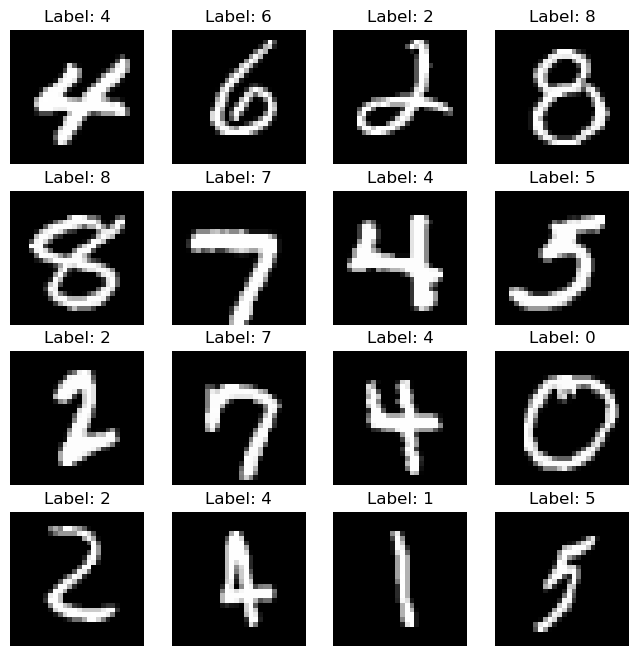

In [9]:
def get_next(loader):
    images, labels = next(iter(loader))
    return images, labels

def visualize_batch(train_loader):
    # Get one batch of training data
    
    images, labels = get_next(train_loader)
    # Plot images in the batch
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i][0], cmap='gray')  # [0] to remove channel dimension
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

def scale_to_amplitude(arr, amplitude):
    scaled_0_1 = (arr + 1.0) / 2.0
    return scaled_0_1 * amplitude

visualize_batch(trainloader)

In [10]:

struct_builder = mc.StructsBuilder()
def connect_inputs_all(pkg, l, r, link_builder, break_limit = 0):
    if not pkg.isValid():
        raise ValueError("invalid pkg")
    if isinstance(r, np.ndarray):
        r = mc.StructsBuilder.grid_to_list(r)
    links = []
    i = 0
    for li, ri in F.iter(list(itertools.product(l, r))):
        i+=1
        if break_limit and i >= break_limit:
            print(f"break agter {i} iterations")
            break
        apt, length = link_builder(li, ri)
        lnk = pkg.new_link_between(apt, length, li, ri)
        links.append(lnk)
    return links, pkg


def make_input_ngrid(pkg, shape:tuple, name_builder, layer_name=""):
    if not shape or not name_builder:
        raise ValueError("invalid params")
    if not pkg.isValid():
        raise ValueError("invalid pkg")
    names = []
    for i in F.iter(itertools.product(*[range(dim) for dim in shape])):
        name = name_builder(i, pkg)
        pkg.new_tape_input(name, [])
        names.append(name)
    if not layer_name:
        layer_name = f"igrid_{F.generateToken()}"
    pkg.addStructureHints({layer_name: names})
    return (layer_name, names, pkg)
    
def neuron_builder(l_index):
    leak = random.uniform(0.1, 1.1)
    peak = random.uniform(5.0, 10.0)
    return (leak, peak)
def link_builder(from_id, to_id):
    apt = random.uniform(0.2, 1.1)
    length = 1
    return (apt, length)
def name_builder(i, pkg):
    name = f"input_{i}"
    if isinstance(i, tuple) or isinstance(i, list) or isinstance(i, set):
        name = "input_" + '.'.join(str(x) for x in i) if i else ''
    oname = name
    salt = 0
    while name in pkg.inputs:
        # dup
        name = f"{oname}_{salt}"
        salt += 1
    return name



In [11]:
images, labels = get_next(trainloader)
amp = 5.0
print(f"count: {len(images)} shape = {images[0].shape}")
      
values = images.flatten().detach().cpu().numpy()
s_values = images[0].detach().cpu().numpy()[0]
print(f"img shape: {s_values.shape} range:{np.min(s_values)} - {np.max(s_values)}")
print("scale...")
s_values = scale_to_amplitude(s_values, amp)
print(f"img shape: {s_values.shape} range:{np.min(s_values)} - {np.max(s_values)}")

count: 64 shape = torch.Size([1, 28, 28])
img shape: (28, 28) range:-1.0 - 1.0
scale...
img shape: (28, 28) range:0.0 - 5.0


In [12]:
pkg = Package.make_empty()
pkg.enable_safe_mode()
print(f"#1 make empty {pkg.counts()}")
inputs_layer_name, input_names, pkg = make_input_ngrid(pkg, s_values.shape, name_builder, "MNIST_IN_layer")
print(f"#2 inputs: ok {pkg.counts()}")
grid_layer_name, grid_inexes, pkg = struct_builder.make_ngrid(pkg, s_values.shape, neuron_builder, "l0")
print(f"#3 l0: ok {pkg.counts()}")

pr = cProfile.Profile()
pr.enable()
links_l0, pkg = connect_inputs_all(pkg, input_names, grid_inexes, link_builder)
pr.disable()
pkg.disable_safe_mode()
#pr.dump_stats('connect_inputs_all.prof')
print(f"#4 l0_connection: ok {pkg.counts()}")



#1 make empty inputs:0, outputs:0, neurons:0, links:0, total:0
v: True


784it [00:00, 371227.63it/s]

#2 inputs: ok inputs:784, outputs:0, neurons:0, links:0, total:784
#3 l0: ok inputs:784, outputs:0, neurons:784, links:0, total:1568


v: True


100%|██████████| 614656/614656 [00:12<00:00, 49045.43it/s]

#4 l0_connection: ok inputs:784, outputs:0, neurons:784, links:614656, total:616224


In [13]:
import io
import pstats
buffer = io.StringIO()
ps = pstats.Stats(pr, stream=buffer).sort_stats('cumulative')
ps.print_stats()
pr.dump_stats('connect_inputs_all.prof')


In [14]:
PackageUIHelper.showGraph(pkg)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
F.set_print_token(inspect.currentframe().f_code.co_name)
db_conf = mstorage.PG_Pool.db_conf_from_env()
pool = mstorage.PG_Pool(db_conf)
storage = mstorage.MgennStorage(pool)
storage.pedantic_validation = True
storage.init()




cycle = mc.CoreLifeCycle()
cycle.i_source = MockInputSource()
cid, o_pkg = push_new_exec_ready(storage)
job, pkg = storage.checkout_executor_job(cid)
if not job or not isinstance(job, mstorage.ExecutorJob) or not job.isValid():
    raise ValueError("no exec job!")
if not pkg or not pkg.isValid():
    raise ValueError("no pkg!")
storage.undo_exec_checkout(cid)
F.set_print_token("")